In [2]:
import numpy as np
import aacgmv2
import datetime
import matplotlib.pyplot as plt
import gzip
import pickle
from scipy import interpolate
import bisect
import os
import scipy.io


import matplotlib.gridspec as gridspec
from solar import daynight_terminator
from scipy.interpolate import interp1d


%load_ext autoreload
# %autoreload 2
# %matplotlib notebook
# %matplotlib notebook
%matplotlib inline


# My own modules:
from xformpy import xflib
xf = xflib.xflib(lib_path='xformpy/libxformd.so')
from index_helpers import load_Kp

### Energy density vs Longitude, L-shell, and frequency plot
#### This is the second half of GLD_statistics_energydensity from the thesis

In [3]:
# Load stencil data:

# (big file to load)
stencil_fn = 'outputs/stencils/stencil_dict_Lshell_power_daynite_with_spectrum_mode6_v3_jan_2018.pkl'

with open(stencil_fn, 'rb') as file:
    stencil_dict = pickle.load(file, encoding='latin1')

In [4]:
# Load Kp
Ktimes, Kp = load_Kp('data/indices/Kp_1999_2018.dat')
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp = np.array(Kp)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp[0:-8],Kp[1:-7],Kp[2:-6], Kp[3:-5], Kp[4:-4],Kp[5:-3],Kp[6:-2], Kp[7:-1], Kp[8:]],axis=0)
Kpmtimes = Ktimes[8:]
unique_Kpm = np.unique(Kpmax)

In [5]:
stencil_lons = stencil_dict['lons']
stencil_freqs = np.sum(np.array(stencil_dict['freq_pairs']), axis=1)/2.  # Center freqs of each bin

inlats = []
inmlts = []
inkps  = []
for k in stencil_dict['data'].keys():
    inlats.append(k[2])
    inmlts.append(k[1])
    inkps.append(k[0])
inlats = np.array(sorted(np.unique(inlats)))
inmlts = np.array(sorted(np.unique(inmlts)))
inkps  = np.array(sorted(np.unique(inkps)))
stencil_Lsh = stencil_dict['Lshells']
stencil_lons = stencil_dict['lons']

# Set up interpolator:
stencil_arr = np.zeros([len(inmlts), len(inlats), len(inkps), len(stencil_Lsh), len(stencil_freqs), len(stencil_lons)])

for key in stencil_dict['data'].keys():
    print(key, end='    \r')
    ilat_ind = bisect.bisect_left(inlats, key[2])
    imlt_ind = bisect.bisect_left(inmlts, key[1])
    ikp_ind  = bisect.bisect_left(inkps, key[0])    
    stencil_arr[imlt_ind, ilat_ind, ikp_ind, :, :, :] = stencil_dict['data'][key]

In [6]:
precalc_stencils = dict()



In [7]:
interp_nite = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_freqs, stencil_lons],
                                                stencil_arr[0], bounds_error=False, fill_value=None)
interp_day = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_freqs, stencil_lons],
                                                stencil_arr[1], bounds_error=False, fill_value=None)

stencil_lons_reduced = np.linspace(-20, 20, 2*20+1)
print(stencil_lons_reduced)
# Set up grid:
# gridlons = np.arange(-180, 180, stencil_dict['d_lon'])
gridlons = np.arange(-180, 180, 1)
gridLs = stencil_dict['Lshells']
gridFs_linear = np.linspace(stencil_freqs[0], stencil_freqs[-1], 100) #stencil_freqs
gridFs = pow(10.,np.linspace(np.log10(stencil_freqs[0]), np.log10(stencil_freqs[-1]), 100)) #stencil_freqs (log scale)
gridFs[0] = gridFs_linear[0]; gridFs[-1] = gridFs_linear[-1]
# gridFs = pow(10,np.linspace(np.log10(stencil_freqs[0]), np.log10(stencil_freqs[-1]), 100)) #stencil_freqs (log scale)
pwr_map = np.zeros([len(gridlons), len(gridLs)])


# Precalculate interpolated stencils:
# precalc_stencils = dict()
xx, yy, zz = np.meshgrid(gridLs, gridFs, stencil_lons_reduced, indexing='ij')
total_jobs = len(np.unique(Kpmax))*len(np.unique(inlats))*len(np.unique(inmlts))
cur_job = 0
for kp in np.unique(Kpmax):
    for lat in np.unique(inlats):
        for mlt in np.unique(inmlts):
            key = (int(np.round(10.*kp)), int(lat), int(mlt))
            cur_job += 1
            if key in precalc_stencils:
                print(f'key {key} already computed', end='     \r')
            else:
    #             print("%d/%d"%(cur_job, total_jobs))
                print(f'key: {key} ({cur_job}/{total_jobs})',end='     \r')
    #             pts = [(lat, kp, x[0], x[1]) for x in zip(xx.ravel(), yy.ravel())]
                pts = list(zip(lat*np.ones_like(xx.ravel()),
                          kp*np.ones_like(xx.ravel()), 
                          xx.ravel(), 
                          yy.ravel(),
                          zz.ravel()))
                if (mlt == inmlts[0]):
                    tmp = interp_nite(pts).reshape(len(gridLs), len(gridFs), len(stencil_lons_reduced))
                elif (mlt == inmlts[1]):
                    tmp = interp_day(pts).reshape(len(gridLs), len(gridFs), len(stencil_lons_reduced))

                precalc_stencils[key] = tmp
            


[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]


In [10]:
# data_path = '../outputs/GLDstats_v8/data/'  # From thesis
# data_path  = 'outputs/GLDstats_v10_CGM/year_avgs/'
# data_path = 'outputs/GLDstats_v10_CGM/data'
data_path = 'outputs/GLDstats_v11/CGM/data/'
# data_path = 'outputs/GLDstats_v11/MAG/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]

# Separate maps for dayside and nightside contributions
pwr_maps = dict()

gridlats = np.arange(-90, 91, 1)


# This one we'll keep split up for each 3-hr block
pwr_maps_canonical_year = dict()

pwr_maps_thesis_method = dict()

count=0
counts = dict()

# Locate all files with common day, month, and time of day, for averaging:
filetime_dict = dict()
# List the files with common time of year
for fi in files:
    it = datetime.datetime.strptime(fi[:-5],'%m_%d_%Y_%H_%M')
    key = it.replace(year=2000) # Arbitrary year, but keep it above the unix epoch for plotting reasons
    if key in filetime_dict:
        filetime_dict[key].append(fi)
    else:
        filetime_dict[key] = [fi]



# Load our previous work! (this crashed 3 or 4 times when running, so I saved our progress)
cache_file = 'cached.pkl'
with open(cache_file,'rb') as file:
    cache = pickle.load(file)
pwr_maps = cache['pwr_maps']
pwr_maps_thesis_method = cache['pwr_maps_thesis_method']
last_cc = cache['last_cc']




for cc, filetime_key in enumerate(sorted(filetime_dict.keys())):
    if cc<= last_cc:
        print(f'skipping {cc}....')
        continue
    v = filetime_dict[filetime_key]
    print(f'Doing {filetime_key}  ({cc} of {len(filetime_dict)})')

    
    for filename in v:
        print(f'\t loading {filename}', end="")
        
        # Initialize the temporary power map -- this will be the average of all 3-hr periods across different years
        temp_power_map = dict()

        # --------- Load and process each day-of-year entry in the current list: ---------
        with gzip.open(os.path.join(data_path, filename)) as f:
            thingy = pickle.load(f)

#             intime = datetime.datetime.strptime(filename,'%m_%d_T%H-%M-%S.pklz')
            intime = datetime.datetime.strptime(filename,'%m_%d_%Y_%H_%M.pklz')

            tcenter = intime + datetime.timedelta(hours=1.5)

            Kpm_index = bisect.bisect_left(Kpmtimes, intime)
            Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp 8
            print(f' -- Kp_max = {Kpm}')

            for is_day in ['day','night']:

                # Load data for day or night
                cur_map = thingy['cur_map'][is_day]
                
                # Just do the hits, please
                todo = np.where(cur_map > 0)
                for x,y in zip(todo[0], todo[1]):
                    I = cur_map[x,y] # sum of squared input currents, in A^2 at the current bin
                    
                    # Latitude and longitude
                    cur_lat = gridlats[x]
                    cur_lon = gridlons[y]
                    
                    # Stencil keys -- Kp, latitude, and MLT (0 or 12)
                    if 'day' in is_day:
                        key = (int(np.round(10.*Kpm)), cur_lat, 12)
                    elif 'night' in is_day:
                        key = (int(np.round(10.*Kpm)), cur_lat, 0)

                    # You can swap out different outkeys here, to look at data over different breakouts.
                    # here, we're just doing it by dayside (true), and nightside (false)
                    outkey = is_day

                    if key in precalc_stencils:
                        # Load the corresponding stencil and scale it by our (summed, squared) current
                        stencil = precalc_stencils[key].swapaxes(0,2)*I
                        # originally (L, F, Lon) --> (Lon, F, L)
                        
                        # Find the center index to apply the stencil at
                        lon_center_ind = bisect.bisect_left(gridlons, cur_lon)
                        lonleft  = lon_center_ind - int(np.floor(len(stencil_lons_reduced)/2)) - 1
                        lonright = lon_center_ind + int(np.floor(len(stencil_lons_reduced)/2))

                        if not outkey in temp_power_map:
                            # initialize temp_power_map with zeros
                            temp_power_map[outkey] = np.zeros([len(gridlons), len(gridFs), len(gridLs)])
                        # Add in the stencil:
                        if lonleft < 0:
                            # wrap left
#                             print('left')
                            temp_power_map[outkey][:lonright,: ]+= stencil[np.abs(lonleft):,:,:]
                            temp_power_map[outkey][(len(gridlons) - np.abs(lonleft)):,:,:] += stencil[0:np.abs(lonleft),:,:]
                        elif lonright > len(gridlons):
                            # wrap right
#                             print('right')
                            temp_power_map[outkey][lonleft:len(gridlons),:,:] += stencil[0:len(gridlons) - lonleft, :,:]
                            temp_power_map[outkey][0:np.abs(lonright) - len(gridlons),:,:] += stencil[len(gridlons) - lonleft,:,:]
                        else:
                            # Middle
#                             print('middle')
                            temp_power_map[outkey][lonleft:lonright, :,:] += stencil

                    
    # Normalize by number of instances:
    print(f'divisor: {len(v)}')
    for el in temp_power_map:
        if el not in pwr_maps:
            # Initialize w/ zeros
            pwr_maps[el] = np.zeros([len(gridlons), len(gridFs), len(gridLs)])
        else:
            # Add to rolling sum
            pwr_maps[el] += (temp_power_map[el])/(1.0*len(v))
        
        # Save this map in the canonical year dict
        pwr_maps_canonical_year[(filetime_key,el)] = (temp_power_map[el])/(1.0*len(v))
            
        # This one is the sum of every entry, regardless of day-of-year. 
        # The only difference between this and the thesis result is the cleaned GLD set........
        if not el in pwr_maps_thesis_method:
            pwr_maps_thesis_method[el] = np.zeros([len(gridlons), len(gridFs), len(gridLs)])
        else:
            pwr_maps_thesis_method[el] += temp_power_map[el]

    # stash our progress here
    cache = dict()
    cache['pwr_maps']=pwr_maps
    cache['pwr_maps_thesis_method'] = pwr_maps_thesis_method
    cache['pwr_maps_canonical_year'] = pwr_maps_canonical_year
    cache['gridLs'] = gridLs
    cache['gridlons'] = gridlons
    cache['gridFs'] = gridFs
    cache['last_cc'] = cc
    print('Saving cache file...')
    with open(cache_file, 'wb') as file:
        pickle.dump(cache, file)

skipping 0....
skipping 1....
skipping 2....
skipping 3....
skipping 4....
skipping 5....
skipping 6....
skipping 7....
skipping 8....
skipping 9....
skipping 10....
skipping 11....
skipping 12....
skipping 13....
skipping 14....
skipping 15....
skipping 16....
skipping 17....
skipping 18....
skipping 19....
skipping 20....
skipping 21....
skipping 22....
skipping 23....
skipping 24....
skipping 25....
skipping 26....
skipping 27....
skipping 28....
skipping 29....
skipping 30....
skipping 31....
skipping 32....
skipping 33....
skipping 34....
skipping 35....
skipping 36....
skipping 37....
skipping 38....
skipping 39....
skipping 40....
skipping 41....
skipping 42....
skipping 43....
skipping 44....
skipping 45....
skipping 46....
skipping 47....
skipping 48....
skipping 49....
skipping 50....
skipping 51....
skipping 52....
skipping 53....
skipping 54....
skipping 55....
skipping 56....
skipping 57....
skipping 58....
skipping 59....
skipping 60....
skipping 61....
skipping 62....
sk

skipping 1820....
skipping 1821....
skipping 1822....
skipping 1823....
skipping 1824....
skipping 1825....
skipping 1826....
skipping 1827....
skipping 1828....
skipping 1829....
skipping 1830....
skipping 1831....
skipping 1832....
skipping 1833....
skipping 1834....
skipping 1835....
skipping 1836....
skipping 1837....
skipping 1838....
skipping 1839....
skipping 1840....
skipping 1841....
skipping 1842....
skipping 1843....
skipping 1844....
skipping 1845....
skipping 1846....
skipping 1847....
skipping 1848....
skipping 1849....
skipping 1850....
skipping 1851....
skipping 1852....
skipping 1853....
skipping 1854....
skipping 1855....
skipping 1856....
skipping 1857....
skipping 1858....
skipping 1859....
skipping 1860....
skipping 1861....
skipping 1862....
skipping 1863....
skipping 1864....
skipping 1865....
skipping 1866....
skipping 1867....
skipping 1868....
skipping 1869....
skipping 1870....
skipping 1871....
skipping 1872....
skipping 1873....
skipping 1874....
skipping 1

	 loading 12_28_2017_15_00.pklz -- Kp_max = 2.7
	 loading 12_28_2012_15_00.pklz -- Kp_max = 0.3
	 loading 12_28_2015_15_00.pklz -- Kp_max = 3.0
divisor: 4
Saving cache file...
Doing 2000-12-28 18:00:00  (2894 of 2920)
	 loading 12_28_2015_18_00.pklz -- Kp_max = 2.3
	 loading 12_28_2017_18_00.pklz -- Kp_max = 2.7
	 loading 12_28_2012_18_00.pklz -- Kp_max = 0.3
	 loading 12_28_2013_18_00.pklz -- Kp_max = 1.0
divisor: 4
Saving cache file...
Doing 2000-12-28 21:00:00  (2895 of 2920)
	 loading 12_28_2013_21_00.pklz -- Kp_max = 1.0
	 loading 12_28_2015_21_00.pklz -- Kp_max = 2.0
	 loading 12_28_2012_21_00.pklz -- Kp_max = 1.0
	 loading 12_28_2017_21_00.pklz -- Kp_max = 2.7
divisor: 4
Saving cache file...
Doing 2000-12-29 00:00:00  (2896 of 2920)
	 loading 12_29_2017_00_00.pklz -- Kp_max = 2.7
	 loading 12_29_2012_00_00.pklz -- Kp_max = 1.0
	 loading 12_29_2015_00_00.pklz -- Kp_max = 2.0
	 loading 12_29_2013_00_00.pklz -- Kp_max = 1.0
divisor: 4
Saving cache file...
Doing 2000-12-29 03:00:00 

In [54]:
cache_file = 'cached.pkl'

with open(cache_file,'rb') as file:
    cache = pickle.load(file)
    print(cache['last_cc'])

2919


In [20]:
# Get current map (from MAG coords instead of CGM)

# data_path = 'outputs/GLDstats_v11/MAG/data/'
d = os.listdir(data_path)
mag_files = [x for x in d if x.endswith('.pklz')]

cur_map_total = np.zeros([181, 360])

for cc, filename in enumerate(mag_files):
    print(f'\t loading {filename} ({cc}/{len(mag_files)})', end='\r')

    # --------- Load and process each day-of-year entry in the current list: ---------
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        cur_map = thingy['cur_map']
        
        cur_map_total += cur_map['day']
        cur_map_total += cur_map['night']
        
#         

	 loading 02_12_2018_00_00.pklz
	 loading 10_01_2017_12_00.pklz
	 loading 06_28_2013_03_00.pklz
	 loading 12_06_2014_12_00.pklz
	 loading 04_28_2014_15_00.pklz
	 loading 09_16_2014_03_00.pklz
	 loading 04_09_2014_00_00.pklz
	 loading 02_26_2015_03_00.pklz
	 loading 12_31_2017_12_00.pklz
	 loading 09_21_2017_03_00.pklz
	 loading 04_18_2013_03_00.pklz
	 loading 09_26_2013_15_00.pklz
	 loading 09_07_2013_00_00.pklz
	 loading 06_09_2013_06_00.pklz
	 loading 11_12_2014_21_00.pklz
	 loading 07_21_2014_21_00.pklz
	 loading 11_18_2016_18_00.pklz
	 loading 02_07_2015_06_00.pklz
	 loading 11_25_2017_21_00.pklz
	 loading 05_11_2014_21_00.pklz
	 loading 03_12_2013_18_00.pklz
	 loading 03_05_2013_03_00.pklz
	 loading 01_24_2014_00_00.pklz
	 loading 01_05_2014_15_00.pklz
	 loading 01_18_2014_12_00.pklz
	 loading 03_14_2014_00_00.pklz
	 loading 03_28_2014_12_00.pklz
	 loading 10_21_2014_09_00.pklz
	 loading 12_01_2012_21_00.pklz
	 loading 12_26_2017_09_00.pklz
	 loading 03_24_2013_06_00.pklz
	 loadin

	 loading 03_25_2015_09_00.pklz
	 loading 11_08_2015_21_00.pklz
	 loading 07_06_2014_18_00.pklz
	 loading 01_05_2013_21_00.pklz
	 loading 08_15_2014_09_00.pklz
	 loading 12_10_2012_06_00.pklz
	 loading 11_02_2017_18_00.pklz
	 loading 11_18_2013_09_00.pklz
	 loading 04_06_2018_06_00.pklz
	 loading 11_15_2017_03_00.pklz
	 loading 05_21_2014_03_00.pklz
	 loading 07_21_2013_15_00.pklz
	 loading 11_12_2013_15_00.pklz
	 loading 08_02_2014_12_00.pklz
	 loading 01_09_2016_00_00.pklz
	 loading 05_11_2013_15_00.pklz
	 loading 01_28_2016_15_00.pklz
	 loading 07_11_2014_03_00.pklz
	 loading 11_22_2014_03_00.pklz
	 loading 04_28_2013_21_00.pklz
	 loading 12_26_2012_18_00.pklz
	 loading 06_08_2015_09_00.pklz
	 loading 02_16_2015_21_00.pklz
	 loading 04_30_2018_18_00.pklz
	 loading 06_18_2013_21_00.pklz
	 loading 11_03_2014_06_00.pklz
	 loading 09_26_2014_21_00.pklz
	 loading 07_30_2014_06_00.pklz
	 loading 02_06_2013_09_00.pklz
	 loading 05_24_2014_06_00.pklz
	 loading 11_10_2017_06_00.pklz
	 loadin

	 loading 01_01_2014_12_00.pklz
	 loading 11_16_2016_03_00.pklz
	 loading 11_30_2012_00_00.pklz
	 loading 08_01_2015_12_00.pklz
	 loading 03_31_2014_12_00.pklz
	 loading 10_23_2013_06_00.pklz
	 loading 08_06_2013_21_00.pklz
	 loading 01_23_2018_21_00.pklz
	 loading 07_05_2015_18_00.pklz
	 loading 03_26_2014_09_00.pklz
	 loading 06_10_2013_06_00.pklz
	 loading 09_19_2017_06_00.pklz
	 loading 05_08_2014_21_00.pklz
	 loading 12_13_2013_06_00.pklz
	 loading 11_01_2016_18_00.pklz
	 loading 04_20_2013_06_00.pklz
	 loading 01_16_2014_09_00.pklz
	 loading 03_13_2018_21_00.pklz
	 loading 10_05_2017_15_00.pklz
	 loading 04_10_2014_00_00.pklz
	 loading 10_24_2017_00_00.pklz
	 loading 10_02_2013_03_00.pklz
	 loading 10_18_2017_12_00.pklz
	 loading 12_02_2014_15_00.pklz
	 loading 12_23_2014_00_00.pklz
	 loading 04_01_2013_03_00.pklz
	 loading 12_14_2017_00_00.pklz
	 loading 06_01_2014_15_00.pklz
	 loading 09_22_2013_12_00.pklz
	 loading 10_13_2014_00_00.pklz
	 loading 12_28_2017_12_00.pklz
	 loadin

	 loading 04_23_2014_12_00.pklz
	 loading 02_25_2018_15_00.pklz
	 loading 12_10_2014_12_00.pklz
	 loading 01_19_2014_09_00.pklz
	 loading 09_16_2017_06_00.pklz
	 loading 02_11_2015_06_00.pklz
	 loading 05_07_2014_21_00.pklz
	 loading 03_04_2013_18_00.pklz
	 loading 09_21_2014_06_00.pklz
	 loading 03_29_2014_09_00.pklz
	 loading 11_04_2014_21_00.pklz
	 loading 08_09_2013_21_00.pklz
	 loading 09_15_2017_00_00.pklz
	 loading 04_10_2013_12_00.pklz
	 loading 02_12_2015_00_00.pklz
	 loading 09_29_2017_12_00.pklz
	 loading 12_23_2013_12_00.pklz
	 loading 02_26_2018_03_00.pklz
	 loading 06_20_2013_12_00.pklz
	 loading 09_03_2014_15_00.pklz
	 loading 10_13_2013_12_00.pklz
	 loading 09_22_2014_00_00.pklz
	 loading 10_09_2017_03_00.pklz
	 loading 09_12_2013_06_00.pklz
	 loading 12_18_2017_06_00.pklz
	 loading 05_24_2015_09_00.pklz
	 loading 11_10_2016_09_00.pklz
	 loading 07_04_2013_21_00.pklz
	 loading 01_07_2014_18_00.pklz
	 loading 10_28_2017_06_00.pklz
	 loading 02_07_2018_06_00.pklz
	 loadin

	 loading 01_06_2016_00_00.pklz
	 loading 08_10_2014_15_00.pklz
	 loading 08_31_2014_00_00.pklz
	 loading 05_04_2014_18_00.pklz
	 loading 03_07_2013_21_00.pklz
	 loading 01_27_2015_09_00.pklz
	 loading 11_30_2017_18_00.pklz
	 loading 12_22_2012_06_00.pklz
	 loading 07_19_2013_09_00.pklz
	 loading 08_27_2014_09_00.pklz
	 loading 03_17_2015_09_00.pklz
	 loading 01_10_2016_09_00.pklz
	 loading 11_07_2014_18_00.pklz
	 loading 12_03_2012_03_00.pklz
	 loading 10_22_2015_00_00.pklz
	 loading 06_11_2015_00_00.pklz
	 loading 04_15_2018_03_00.pklz
	 loading 06_30_2015_15_00.pklz
	 loading 12_12_2015_00_00.pklz
	 loading 10_29_2016_12_00.pklz
	 loading 02_23_2013_12_00.pklz
	 loading 04_21_2015_00_00.pklz
	 loading 10_19_2013_21_00.pklz
	 loading 07_02_2014_06_00.pklz
	 loading 09_14_2014_21_00.pklz
	 loading 01_19_2018_06_00.pklz
	 loading 04_02_2018_18_00.pklz
	 loading 09_23_2017_21_00.pklz
	 loading 12_29_2013_21_00.pklz
	 loading 11_06_2017_06_00.pklz
	 loading 02_24_2015_21_00.pklz
	 loadin

	 loading 10_29_2014_09_00.pklz
	 loading 02_04_2014_21_00.pklz
	 loading 04_07_2013_18_00.pklz
	 loading 09_24_2013_09_00.pklz
	 loading 12_19_2014_09_00.pklz
	 loading 09_09_2014_18_00.pklz
	 loading 10_04_2013_18_00.pklz
	 loading 11_11_2015_06_00.pklz
	 loading 12_13_2014_15_00.pklz
	 loading 10_13_2013_03_00.pklz
	 loading 10_09_2017_12_00.pklz
	 loading 06_20_2013_03_00.pklz
	 loading 04_01_2014_00_00.pklz
	 loading 10_14_2017_15_00.pklz
	 loading 04_20_2014_15_00.pklz
	 loading 02_26_2018_12_00.pklz
	 loading 12_23_2013_03_00.pklz
	 loading 10_23_2014_15_00.pklz
	 loading 09_29_2017_03_00.pklz
	 loading 10_02_2014_00_00.pklz
	 loading 12_24_2017_15_00.pklz
	 loading 12_05_2017_00_00.pklz
	 loading 04_10_2013_03_00.pklz
	 loading 06_01_2013_06_00.pklz
	 loading 08_17_2013_21_00.pklz
	 loading 07_29_2014_21_00.pklz
	 loading 03_02_2018_21_00.pklz
	 loading 05_24_2015_18_00.pklz
	 loading 01_07_2014_09_00.pklz
	 loading 11_10_2016_18_00.pklz
	 loading 05_19_2014_21_00.pklz
	 loadin

	 loading 12_07_2013_03_00.pklz
	 loading 10_26_2014_00_00.pklz
	 loading 10_07_2014_15_00.pklz
	 loading 09_17_2013_12_00.pklz
	 loading 12_10_2013_18_00.pklz
	 loading 03_08_2013_06_00.pklz
	 loading 04_23_2013_18_00.pklz
	 loading 11_02_2016_06_00.pklz
	 loading 10_20_2013_18_00.pklz
	 loading 06_13_2013_18_00.pklz
	 loading 07_06_2015_06_00.pklz
	 loading 02_15_2018_09_00.pklz
	 loading 03_29_2013_03_00.pklz
	 loading 01_08_2014_00_00.pklz
	 loading 01_29_2014_15_00.pklz
	 loading 03_19_2014_15_00.pklz
	 loading 11_14_2015_03_00.pklz
	 loading 08_14_2013_18_00.pklz
	 loading 03_09_2015_09_00.pklz
	 loading 01_29_2013_21_00.pklz
	 loading 11_19_2014_18_00.pklz
	 loading 03_19_2013_21_00.pklz
	 loading 03_01_2018_18_00.pklz
	 loading 07_07_2013_09_00.pklz
	 loading 11_13_2016_21_00.pklz
	 loading 05_27_2015_21_00.pklz
	 loading 04_03_2015_12_00.pklz
	 loading 02_20_2013_15_00.pklz
	 loading 02_01_2013_00_00.pklz
	 loading 12_30_2015_12_00.pklz
	 loading 02_10_2014_03_00.pklz
	 loadin

	 loading 10_01_2017_03_00.pklz
	 loading 06_14_2013_00_00.pklz
	 loading 12_10_2017_06_00.pklz
	 loading 03_12_2013_09_00.pklz
	 loading 10_17_2014_06_00.pklz
	 loading 11_18_2016_09_00.pklz
	 loading 10_20_2017_06_00.pklz
	 loading 03_02_2015_21_00.pklz
	 loading 04_14_2014_06_00.pklz
	 loading 01_05_2016_21_00.pklz
	 loading 03_15_2014_03_00.pklz
	 loading 01_15_2013_15_00.pklz
	 loading 11_05_2015_12_00.pklz
	 loading 01_08_2013_12_00.pklz
	 loading 03_25_2013_15_00.pklz
	 loading 03_04_2013_00_00.pklz
	 loading 01_25_2014_03_00.pklz
	 loading 05_06_2015_12_00.pklz
	 loading 12_11_2015_21_00.pklz
	 loading 10_31_2013_09_00.pklz
	 loading 06_02_2013_09_00.pklz
	 loading 04_22_2015_21_00.pklz
	 loading 02_04_2018_18_00.pklz
	 loading 10_21_2015_21_00.pklz
	 loading 12_01_2013_09_00.pklz
	 loading 09_11_2013_18_00.pklz
	 loading 01_04_2014_06_00.pklz
	 loading 06_12_2015_21_00.pklz
	 loading 02_27_2015_00_00.pklz
	 loading 02_06_2015_15_00.pklz
	 loading 09_20_2017_00_00.pklz
	 loadin

	 loading 02_17_2013_00_00.pklz
	 loading 10_21_2016_12_00.pklz
	 loading 04_15_2015_12_00.pklz
	 loading 12_26_2015_12_00.pklz
	 loading 04_08_2015_15_00.pklz
	 loading 04_29_2015_00_00.pklz
	 loading 08_31_2014_18_00.pklz
	 loading 03_09_2018_09_00.pklz
	 loading 05_12_2014_09_00.pklz
	 loading 11_26_2017_09_00.pklz
	 loading 10_29_2015_06_00.pklz
	 loading 11_11_2014_09_00.pklz
	 loading 01_06_2016_18_00.pklz
	 loading 02_14_2013_06_00.pklz
	 loading 07_22_2014_09_00.pklz
	 loading 03_01_2015_18_00.pklz
	 loading 12_19_2015_06_00.pklz
	 loading 04_03_2018_12_00.pklz
	 loading 12_29_2012_00_00.pklz
	 loading 02_05_2014_15_00.pklz
	 loading 12_08_2012_15_00.pklz
	 loading 12_15_2012_12_00.pklz
	 loading 10_28_2016_18_00.pklz
	 loading 01_30_2016_06_00.pklz
	 loading 05_09_2013_06_00.pklz
	 loading 12_12_2014_21_00.pklz
	 loading 02_22_2013_18_00.pklz
	 loading 04_21_2014_21_00.pklz
	 loading 10_15_2017_21_00.pklz
	 loading 12_02_2012_09_00.pklz
	 loading 10_22_2014_21_00.pklz
	 loadin

	 loading 02_07_2018_15_00.pklz
	 loading 02_26_2018_00_00.pklz
	 loading 09_12_2013_15_00.pklz
	 loading 10_02_2014_12_00.pklz
	 loading 12_18_2017_15_00.pklz
	 loading 09_15_2017_03_00.pklz
	 loading 02_12_2015_03_00.pklz
	 loading 12_05_2017_12_00.pklz
	 loading 07_15_2014_21_00.pklz
	 loading 09_03_2014_06_00.pklz
	 loading 11_26_2014_21_00.pklz
	 loading 03_26_2013_18_00.pklz
	 loading 05_25_2014_21_00.pklz
	 loading 11_11_2017_21_00.pklz
	 loading 05_18_2015_18_00.pklz
	 loading 01_31_2014_15_00.pklz
	 loading 01_10_2014_00_00.pklz
	 loading 03_31_2013_03_00.pklz
	 loading 01_01_2013_03_00.pklz
	 loading 03_20_2014_00_00.pklz
	 loading 04_23_2018_21_00.pklz
	 loading 09_18_2013_09_00.pklz
	 loading 03_10_2013_06_00.pklz
	 loading 12_08_2013_18_00.pklz
	 loading 12_12_2017_09_00.pklz
	 loading 02_05_2015_18_00.pklz
	 loading 10_15_2014_09_00.pklz
	 loading 04_16_2014_09_00.pklz
	 loading 10_22_2017_09_00.pklz
	 loading 11_19_2016_00_00.pklz
	 loading 05_11_2015_12_00.pklz
	 loadin

	 loading 11_22_2013_12_00.pklz
	 loading 03_17_2018_03_00.pklz
	 loading 07_11_2013_12_00.pklz
	 loading 01_24_2016_00_00.pklz
	 loading 08_02_2013_03_00.pklz
	 loading 01_05_2016_15_00.pklz
	 loading 01_18_2016_12_00.pklz
	 loading 03_23_2015_00_00.pklz
	 loading 03_02_2015_15_00.pklz
	 loading 11_18_2014_18_00.pklz
	 loading 08_15_2013_18_00.pklz
	 loading 03_08_2015_09_00.pklz
	 loading 01_28_2013_21_00.pklz
	 loading 07_06_2013_09_00.pklz
	 loading 11_12_2016_21_00.pklz
	 loading 05_26_2015_21_00.pklz
	 loading 03_18_2013_21_00.pklz
	 loading 12_31_2015_12_00.pklz
	 loading 04_02_2015_12_00.pklz
	 loading 02_21_2013_15_00.pklz
	 loading 02_11_2014_03_00.pklz
	 loading 06_18_2015_09_00.pklz
	 loading 04_20_2018_18_00.pklz
	 loading 11_24_2017_06_00.pklz
	 loading 02_06_2015_21_00.pklz
	 loading 05_10_2014_06_00.pklz
	 loading 06_08_2013_21_00.pklz
	 loading 11_13_2014_06_00.pklz
	 loading 04_28_2015_09_00.pklz
	 loading 07_20_2014_06_00.pklz
	 loading 02_16_2013_09_00.pklz
	 loadin

	 loading 10_17_2013_06_00.pklz
	 loading 03_27_2018_21_00.pklz
	 loading 01_22_2014_09_00.pklz
	 loading 04_14_2013_06_00.pklz
	 loading 05_01_2015_18_00.pklz
	 loading 11_08_2017_21_00.pklz
	 loading 12_27_2013_06_00.pklz
	 loading 12_17_2014_00_00.pklz
	 loading 04_18_2014_12_00.pklz
	 loading 06_05_2013_03_00.pklz
	 loading 10_10_2017_00_00.pklz
	 loading 02_03_2018_12_00.pklz
	 loading 04_05_2014_15_00.pklz
	 loading 10_31_2017_15_00.pklz
	 loading 04_24_2014_00_00.pklz
	 loading 12_06_2013_03_00.pklz
	 loading 10_27_2014_00_00.pklz
	 loading 10_06_2014_15_00.pklz
	 loading 09_16_2013_12_00.pklz
	 loading 12_20_2017_00_00.pklz
	 loading 12_01_2017_15_00.pklz
	 loading 10_10_2015_03_00.pklz
	 loading 12_10_2012_15_00.pklz
	 loading 12_31_2012_00_00.pklz
	 loading 04_06_2018_15_00.pklz
	 loading 06_23_2015_03_00.pklz
	 loading 04_27_2018_00_00.pklz
	 loading 12_20_2015_03_00.pklz
	 loading 10_27_2016_03_00.pklz
	 loading 04_13_2015_03_00.pklz
	 loading 08_29_2014_18_00.pklz
	 loadin

	 loading 01_19_2014_03_00.pklz
	 loading 03_19_2013_15_00.pklz
	 loading 12_10_2014_18_00.pklz
	 loading 03_08_2014_06_00.pklz
	 loading 10_17_2017_18_00.pklz
	 loading 04_23_2014_18_00.pklz
	 loading 02_20_2013_21_00.pklz
	 loading 10_20_2014_18_00.pklz
	 loading 12_27_2017_18_00.pklz
	 loading 12_17_2013_12_00.pklz
	 loading 04_18_2013_00_00.pklz
	 loading 09_07_2013_03_00.pklz
	 loading 02_26_2015_00_00.pklz
	 loading 02_07_2015_15_00.pklz
	 loading 09_21_2017_00_00.pklz
	 loading 04_24_2013_12_00.pklz
	 loading 06_28_2013_00_00.pklz
	 loading 06_09_2013_15_00.pklz
	 loading 09_16_2014_00_00.pklz
	 loading 10_27_2013_12_00.pklz
	 loading 04_09_2014_03_00.pklz
	 loading 02_12_2018_03_00.pklz
	 loading 07_30_2013_21_00.pklz
	 loading 05_10_2015_09_00.pklz
	 loading 11_03_2013_21_00.pklz
	 loading 09_26_2013_06_00.pklz
	 loading 11_13_2015_09_00.pklz
	 loading 04_28_2014_06_00.pklz
	 loading 11_04_2015_12_00.pklz
	 loading 01_09_2013_12_00.pklz
	 loading 03_14_2014_03_00.pklz
	 loadin

	 loading 12_03_2012_09_00.pklz
	 loading 10_23_2014_21_00.pklz
	 loading 08_06_2014_06_00.pklz
	 loading 07_08_2014_00_00.pklz
	 loading 07_29_2014_15_00.pklz
	 loading 01_10_2016_03_00.pklz
	 loading 08_17_2013_15_00.pklz
	 loading 11_07_2014_12_00.pklz
	 loading 03_17_2015_03_00.pklz
	 loading 01_13_2018_00_00.pklz
	 loading 07_19_2013_03_00.pklz
	 loading 08_27_2014_03_00.pklz
	 loading 05_19_2014_15_00.pklz
	 loading 05_04_2014_12_00.pklz
	 loading 03_02_2018_15_00.pklz
	 loading 01_27_2015_03_00.pklz
	 loading 11_30_2017_12_00.pklz
	 loading 03_23_2018_00_00.pklz
	 loading 05_13_2014_09_00.pklz
	 loading 11_27_2017_09_00.pklz
	 loading 10_28_2015_06_00.pklz
	 loading 08_30_2014_18_00.pklz
	 loading 03_08_2018_09_00.pklz
	 loading 02_15_2013_06_00.pklz
	 loading 07_23_2014_09_00.pklz
	 loading 12_18_2015_06_00.pklz
	 loading 11_10_2014_09_00.pklz
	 loading 01_07_2016_18_00.pklz
	 loading 12_14_2012_12_00.pklz
	 loading 04_02_2018_12_00.pklz
	 loading 02_04_2014_15_00.pklz
	 loadin

	 loading 01_24_2014_12_00.pklz
	 loading 11_29_2012_12_00.pklz
	 loading 05_07_2015_03_00.pklz
	 loading 01_18_2014_00_00.pklz
	 loading 03_14_2014_12_00.pklz
	 loading 11_04_2015_03_00.pklz
	 loading 01_09_2013_03_00.pklz
	 loading 03_28_2014_00_00.pklz
	 loading 03_09_2014_15_00.pklz
	 loading 09_10_2013_09_00.pklz
	 loading 03_18_2013_06_00.pklz
	 loading 11_12_2016_06_00.pklz
	 loading 05_26_2015_06_00.pklz
	 loading 01_28_2013_06_00.pklz
	 loading 10_30_2013_18_00.pklz
	 loading 02_05_2018_09_00.pklz
	 loading 06_03_2013_18_00.pklz
	 loading 04_14_2014_15_00.pklz
	 loading 02_12_2018_12_00.pklz
	 loading 10_01_2017_00_00.pklz
	 loading 10_20_2017_15_00.pklz
	 loading 04_09_2014_12_00.pklz
	 loading 10_27_2013_03_00.pklz
	 loading 12_06_2014_00_00.pklz
	 loading 04_24_2013_03_00.pklz
	 loading 12_31_2017_00_00.pklz
	 loading 12_10_2017_15_00.pklz
	 loading 10_17_2014_15_00.pklz
	 loading 09_07_2013_12_00.pklz
	 loading 12_17_2013_03_00.pklz
	 loading 11_13_2015_18_00.pklz
	 loadin

	 loading 02_08_2013_00_00.pklz
	 loading 12_24_2015_15_00.pklz
	 loading 12_05_2015_00_00.pklz
	 loading 10_09_2015_12_00.pklz
	 loading 06_06_2015_00_00.pklz
	 loading 04_02_2018_03_00.pklz
	 loading 06_27_2015_15_00.pklz
	 loading 10_14_2015_15_00.pklz
	 loading 12_14_2012_03_00.pklz
	 loading 12_03_2012_18_00.pklz
	 loading 05_25_2014_06_00.pklz
	 loading 11_11_2017_06_00.pklz
	 loading 04_15_2018_18_00.pklz
	 loading 11_26_2014_06_00.pklz
	 loading 10_29_2016_09_00.pklz
	 loading 09_03_2014_21_00.pklz
	 loading 02_23_2013_09_00.pklz
	 loading 07_15_2014_06_00.pklz
	 loading 05_04_2014_03_00.pklz
	 loading 11_30_2017_03_00.pklz
	 loading 01_27_2015_12_00.pklz
	 loading 07_04_2013_15_00.pklz
	 loading 07_25_2013_00_00.pklz
	 loading 11_16_2013_00_00.pklz
	 loading 08_27_2014_12_00.pklz
	 loading 07_19_2013_12_00.pklz
	 loading 05_15_2013_00_00.pklz
	 loading 03_17_2015_12_00.pklz
	 loading 11_07_2014_03_00.pklz
	 loading 01_10_2016_12_00.pklz
	 loading 01_05_2018_18_00.pklz
	 loadin

	 loading 09_29_2017_00_00.pklz
	 loading 06_01_2013_15_00.pklz
	 loading 06_20_2013_00_00.pklz
	 loading 04_01_2014_03_00.pklz
	 loading 10_13_2013_00_00.pklz
	 loading 09_22_2014_12_00.pklz
	 loading 08_06_2014_21_00.pklz
	 loading 05_18_2015_09_00.pklz
	 loading 10_23_2014_06_00.pklz
	 loading 03_26_2013_09_00.pklz
	 loading 12_24_2017_06_00.pklz
	 loading 05_08_2013_21_00.pklz
	 loading 12_13_2014_06_00.pklz
	 loading 01_31_2016_21_00.pklz
	 loading 04_20_2014_06_00.pklz
	 loading 10_14_2017_06_00.pklz
	 loading 01_23_2018_15_00.pklz
	 loading 07_25_2014_12_00.pklz
	 loading 01_02_2018_00_00.pklz
	 loading 03_06_2015_03_00.pklz
	 loading 08_27_2013_00_00.pklz
	 loading 08_06_2013_15_00.pklz
	 loading 11_16_2014_12_00.pklz
	 loading 01_01_2016_03_00.pklz
	 loading 07_19_2014_00_00.pklz
	 loading 03_13_2018_15_00.pklz
	 loading 05_15_2014_12_00.pklz
	 loading 11_21_2017_12_00.pklz
	 loading 05_29_2014_00_00.pklz
	 loading 05_08_2014_15_00.pklz
	 loading 07_08_2013_03_00.pklz
	 loadin

	 loading 04_15_2015_18_00.pklz
	 loading 09_26_2013_21_00.pklz
	 loading 10_16_2015_18_00.pklz
	 loading 11_03_2013_06_00.pklz
	 loading 07_30_2013_06_00.pklz
	 loading 02_06_2014_09_00.pklz
	 loading 06_25_2015_18_00.pklz
	 loading 07_21_2014_15_00.pklz
	 loading 01_18_2016_03_00.pklz
	 loading 11_12_2014_15_00.pklz
	 loading 08_02_2013_12_00.pklz
	 loading 07_11_2013_03_00.pklz
	 loading 05_11_2014_15_00.pklz
	 loading 11_04_2017_00_00.pklz
	 loading 03_17_2018_12_00.pklz
	 loading 05_30_2014_00_00.pklz
	 loading 11_25_2017_15_00.pklz
	 loading 11_22_2013_03_00.pklz
	 loading 11_12_2017_09_00.pklz
	 loading 05_26_2014_09_00.pklz
	 loading 08_05_2014_18_00.pklz
	 loading 08_28_2013_09_00.pklz
	 loading 07_16_2014_09_00.pklz
	 loading 02_20_2013_06_00.pklz
	 loading 03_08_2014_21_00.pklz
	 loading 11_25_2014_09_00.pklz
	 loading 12_21_2012_12_00.pklz
	 loading 02_10_2014_00_00.pklz
	 loading 02_01_2013_03_00.pklz
	 loading 03_03_2015_06_00.pklz
	 loading 10_21_2017_21_00.pklz
	 loadin

	 loading 07_29_2014_18_00.pklz
	 loading 04_08_2018_03_00.pklz
	 loading 06_30_2015_12_00.pklz
	 loading 10_29_2016_15_00.pklz
	 loading 02_23_2013_15_00.pklz
	 loading 02_02_2013_00_00.pklz
	 loading 11_29_2013_18_00.pklz
	 loading 05_07_2014_09_00.pklz
	 loading 01_24_2015_18_00.pklz
	 loading 08_24_2014_18_00.pklz
	 loading 01_19_2014_21_00.pklz
	 loading 08_09_2013_09_00.pklz
	 loading 02_01_2013_06_00.pklz
	 loading 03_14_2015_18_00.pklz
	 loading 03_29_2014_21_00.pklz
	 loading 11_04_2014_09_00.pklz
	 loading 01_13_2016_18_00.pklz
	 loading 04_16_2018_12_00.pklz
	 loading 02_10_2014_15_00.pklz
	 loading 02_20_2013_03_00.pklz
	 loading 03_22_2015_06_00.pklz
	 loading 01_25_2016_06_00.pklz
	 loading 12_07_2014_21_00.pklz
	 loading 12_30_2017_21_00.pklz
	 loading 04_01_2018_09_00.pklz
	 loading 08_12_2014_06_00.pklz
	 loading 12_17_2012_09_00.pklz
	 loading 08_22_2013_00_00.pklz
	 loading 01_04_2016_03_00.pklz
	 loading 11_13_2014_12_00.pklz
	 loading 08_03_2013_15_00.pklz
	 loadin

	 loading 12_10_2014_15_00.pklz
	 loading 10_10_2013_03_00.pklz
	 loading 02_19_2018_00_00.pklz
	 loading 12_01_2013_06_00.pklz
	 loading 03_19_2013_18_00.pklz
	 loading 03_01_2018_21_00.pklz
	 loading 05_27_2015_18_00.pklz
	 loading 01_04_2014_09_00.pklz
	 loading 11_13_2016_18_00.pklz
	 loading 08_14_2013_21_00.pklz
	 loading 01_29_2013_18_00.pklz
	 loading 10_31_2013_06_00.pklz
	 loading 06_02_2013_06_00.pklz
	 loading 11_19_2014_21_00.pklz
	 loading 03_23_2014_12_00.pklz
	 loading 05_30_2015_03_00.pklz
	 loading 11_04_2016_03_00.pklz
	 loading 01_13_2014_12_00.pklz
	 loading 10_07_2013_18_00.pklz
	 loading 04_29_2014_09_00.pklz
	 loading 11_12_2015_06_00.pklz
	 loading 09_27_2013_09_00.pklz
	 loading 05_11_2015_06_00.pklz
	 loading 02_07_2014_21_00.pklz
	 loading 04_04_2013_18_00.pklz
	 loading 07_03_2015_15_00.pklz
	 loading 11_11_2015_00_00.pklz
	 loading 03_10_2013_12_00.pklz
	 loading 05_12_2015_00_00.pklz
	 loading 11_07_2016_15_00.pklz
	 loading 12_04_2014_18_00.pklz
	 loadin

	 loading 11_02_2015_15_00.pklz
	 loading 01_12_2013_12_00.pklz
	 loading 07_31_2015_15_00.pklz
	 loading 01_05_2013_09_00.pklz
	 loading 03_25_2015_21_00.pklz
	 loading 11_08_2015_09_00.pklz
	 loading 10_07_2017_06_00.pklz
	 loading 02_28_2018_06_00.pklz
	 loading 01_22_2016_21_00.pklz
	 loading 03_18_2014_18_00.pklz
	 loading 11_18_2013_21_00.pklz
	 loading 01_28_2014_18_00.pklz
	 loading 10_30_2014_06_00.pklz
	 loading 08_15_2014_21_00.pklz
	 loading 02_09_2018_03_00.pklz
	 loading 10_21_2013_15_00.pklz
	 loading 12_21_2014_03_00.pklz
	 loading 04_12_2014_03_00.pklz
	 loading 10_26_2017_03_00.pklz
	 loading 06_12_2013_15_00.pklz
	 loading 10_11_2014_03_00.pklz
	 loading 12_30_2013_00_00.pklz
	 loading 12_11_2013_15_00.pklz
	 loading 04_22_2013_15_00.pklz
	 loading 04_03_2013_00_00.pklz
	 loading 12_16_2017_03_00.pklz
	 loading 12_26_2013_09_00.pklz
	 loading 01_23_2014_06_00.pklz
	 loading 04_15_2013_09_00.pklz
	 loading 10_16_2013_09_00.pklz
	 loading 04_05_2015_21_00.pklz
	 loadin

	 loading 03_21_2018_00_00.pklz
	 loading 01_12_2016_03_00.pklz
	 loading 11_05_2014_12_00.pklz
	 loading 08_15_2013_15_00.pklz
	 loading 03_15_2015_03_00.pklz
	 loading 01_11_2018_00_00.pklz
	 loading 11_18_2014_15_00.pklz
	 loading 08_08_2013_12_00.pklz
	 loading 07_21_2014_09_00.pklz
	 loading 02_17_2013_06_00.pklz
	 loading 03_02_2015_18_00.pklz
	 loading 04_29_2015_06_00.pklz
	 loading 11_12_2014_09_00.pklz
	 loading 01_05_2016_18_00.pklz
	 loading 05_11_2014_09_00.pklz
	 loading 11_25_2017_09_00.pklz
	 loading 06_19_2015_06_00.pklz
	 loading 04_08_2015_03_00.pklz
	 loading 12_16_2012_12_00.pklz
	 loading 02_06_2014_15_00.pklz
	 loading 02_12_2013_03_00.pklz
	 loading 10_18_2016_03_00.pklz
	 loading 02_03_2014_00_00.pklz
	 loading 04_24_2018_12_00.pklz
	 loading 04_18_2018_00_00.pklz
	 loading 01_21_2016_18_00.pklz
	 loading 03_26_2015_18_00.pklz
	 loading 07_05_2014_09_00.pklz
	 loading 07_28_2013_18_00.pklz
	 loading 08_16_2014_18_00.pklz
	 loading 11_01_2017_09_00.pklz
	 loadin

	 loading 12_18_2017_18_00.pklz
	 loading 10_22_2015_21_00.pklz
	 loading 12_02_2013_09_00.pklz
	 loading 09_12_2013_18_00.pklz
	 loading 06_01_2013_09_00.pklz
	 loading 04_21_2015_21_00.pklz
	 loading 02_07_2018_18_00.pklz
	 loading 10_28_2017_18_00.pklz
	 loading 12_12_2015_21_00.pklz
	 loading 10_02_2017_03_00.pklz
	 loading 09_29_2014_00_00.pklz
	 loading 09_08_2014_15_00.pklz
	 loading 10_18_2013_12_00.pklz
	 loading 06_17_2013_00_00.pklz
	 loading 09_15_2014_12_00.pklz
	 loading 10_05_2013_15_00.pklz
	 loading 10_24_2013_00_00.pklz
	 loading 12_05_2014_03_00.pklz
	 loading 09_22_2017_12_00.pklz
	 loading 04_27_2013_00_00.pklz
	 loading 04_06_2013_15_00.pklz
	 loading 02_25_2015_12_00.pklz
	 loading 12_28_2013_12_00.pklz
	 loading 02_19_2015_00_00.pklz
	 loading 12_14_2013_00_00.pklz
	 loading 01_06_2016_21_00.pklz
	 loading 10_23_2017_06_00.pklz
	 loading 03_01_2015_21_00.pklz
	 loading 04_17_2014_06_00.pklz
	 loading 10_14_2014_06_00.pklz
	 loading 08_31_2014_21_00.pklz
	 loadin

	 loading 11_14_2013_00_00.pklz
	 loading 08_25_2014_12_00.pklz
	 loading 10_08_2017_21_00.pklz
	 loading 05_14_2013_06_00.pklz
	 loading 04_01_2015_18_00.pklz
	 loading 02_27_2018_21_00.pklz
	 loading 11_17_2013_06_00.pklz
	 loading 04_09_2018_09_00.pklz
	 loading 07_24_2013_06_00.pklz
	 loading 07_14_2014_00_00.pklz
	 loading 11_27_2014_00_00.pklz
	 loading 08_16_2013_12_00.pklz
	 loading 11_06_2014_15_00.pklz
	 loading 07_28_2014_12_00.pklz
	 loading 05_05_2014_15_00.pklz
	 loading 03_03_2018_12_00.pklz
	 loading 11_10_2017_00_00.pklz
	 loading 05_24_2014_00_00.pklz
	 loading 07_05_2013_03_00.pklz
	 loading 05_18_2014_12_00.pklz
	 loading 11_21_2013_18_00.pklz
	 loading 03_14_2018_09_00.pklz
	 loading 07_12_2013_18_00.pklz
	 loading 01_11_2014_21_00.pklz
	 loading 06_07_2015_06_00.pklz
	 loading 08_01_2013_09_00.pklz
	 loading 12_04_2015_06_00.pklz
	 loading 02_09_2013_06_00.pklz
	 loading 03_21_2014_21_00.pklz
	 loading 01_24_2018_09_00.pklz
	 loading 04_03_2018_15_00.pklz
	 loadin

	 loading 01_06_2014_15_00.pklz
	 loading 10_15_2017_09_00.pklz
	 loading 04_21_2014_09_00.pklz
	 loading 12_12_2014_09_00.pklz
	 loading 09_02_2014_18_00.pklz
	 loading 12_25_2017_09_00.pklz
	 loading 03_27_2013_06_00.pklz
	 loading 04_14_2018_21_00.pklz
	 loading 10_22_2014_09_00.pklz
	 loading 05_19_2015_06_00.pklz
	 loading 12_02_2012_21_00.pklz
	 loading 09_25_2013_15_00.pklz
	 loading 09_04_2013_00_00.pklz
	 loading 02_25_2015_03_00.pklz
	 loading 12_28_2013_03_00.pklz
	 loading 10_09_2014_00_00.pklz
	 loading 09_22_2017_03_00.pklz
	 loading 10_28_2014_15_00.pklz
	 loading 12_05_2014_12_00.pklz
	 loading 09_15_2014_03_00.pklz
	 loading 12_18_2014_15_00.pklz
	 loading 02_11_2018_00_00.pklz
	 loading 10_02_2017_12_00.pklz
	 loading 10_18_2013_03_00.pklz
	 loading 11_26_2017_21_00.pklz
	 loading 05_12_2014_21_00.pklz
	 loading 03_11_2013_18_00.pklz
	 loading 12_09_2013_06_00.pklz
	 loading 03_09_2018_21_00.pklz
	 loading 07_22_2014_21_00.pklz
	 loading 11_11_2014_21_00.pklz
	 loadin

	 loading 02_01_2018_03_00.pklz
	 loading 10_08_2013_00_00.pklz
	 loading 06_07_2013_12_00.pklz
	 loading 09_05_2014_00_00.pklz
	 loading 09_24_2014_15_00.pklz
	 loading 10_19_2014_03_00.pklz
	 loading 09_13_2017_15_00.pklz
	 loading 12_19_2013_15_00.pklz
	 loading 02_14_2015_15_00.pklz
	 loading 09_14_2013_03_00.pklz
	 loading 02_09_2015_12_00.pklz
	 loading 12_04_2013_12_00.pklz
	 loading 09_19_2017_09_00.pklz
	 loading 09_03_2013_18_00.pklz
	 loading 12_09_2017_18_00.pklz
	 loading 12_13_2013_09_00.pklz
	 loading 04_20_2013_09_00.pklz
	 loading 01_16_2014_06_00.pklz
	 loading 12_03_2015_21_00.pklz
	 loading 10_23_2013_09_00.pklz
	 loading 02_16_2018_18_00.pklz
	 loading 03_26_2014_06_00.pklz
	 loading 06_10_2013_09_00.pklz
	 loading 04_30_2015_21_00.pklz
	 loading 05_14_2015_12_00.pklz
	 loading 03_16_2013_00_00.pklz
	 loading 05_09_2015_15_00.pklz
	 loading 05_28_2015_00_00.pklz
	 loading 01_07_2013_15_00.pklz
	 loading 01_26_2013_00_00.pklz
	 loading 03_07_2014_03_00.pklz
	 loadin

	 loading 09_30_2013_03_00.pklz
	 loading 12_20_2013_12_00.pklz
	 loading 09_16_2017_00_00.pklz
	 loading 04_13_2013_12_00.pklz
	 loading 02_11_2015_00_00.pklz
	 loading 02_04_2018_06_00.pklz
	 loading 01_29_2013_09_00.pklz
	 loading 03_09_2015_21_00.pklz
	 loading 05_27_2015_09_00.pklz
	 loading 11_13_2016_09_00.pklz
	 loading 07_07_2013_21_00.pklz
	 loading 01_04_2014_18_00.pklz
	 loading 09_11_2013_06_00.pklz
	 loading 03_19_2013_09_00.pklz
	 loading 11_04_2013_03_00.pklz
	 loading 11_03_2017_15_00.pklz
	 loading 05_16_2014_00_00.pklz
	 loading 03_31_2018_12_00.pklz
	 loading 11_22_2017_00_00.pklz
	 loading 08_09_2014_03_00.pklz
	 loading 08_24_2013_12_00.pklz
	 loading 11_15_2014_00_00.pklz
	 loading 07_26_2014_00_00.pklz
	 loading 01_01_2018_12_00.pklz
	 loading 07_07_2014_15_00.pklz
	 loading 08_18_2013_00_00.pklz
	 loading 05_07_2013_03_00.pklz
	 loading 11_29_2014_12_00.pklz
	 loading 06_03_2015_18_00.pklz
	 loading 07_16_2013_06_00.pklz
	 loading 08_28_2014_06_00.pklz
	 loadin

	 loading 07_04_2013_03_00.pklz
	 loading 08_10_2014_18_00.pklz
	 loading 03_28_2018_09_00.pklz
	 loading 11_07_2017_09_00.pklz
	 loading 01_18_2018_09_00.pklz
	 loading 11_30_2014_09_00.pklz
	 loading 01_27_2016_18_00.pklz
	 loading 03_20_2015_18_00.pklz
	 loading 07_03_2014_09_00.pklz
	 loading 02_05_2014_00_00.pklz
	 loading 12_29_2012_15_00.pklz
	 loading 04_22_2018_12_00.pklz
	 loading 12_08_2012_00_00.pklz
	 loading 10_29_2015_03_00.pklz
	 loading 12_19_2015_03_00.pklz
	 loading 02_14_2013_03_00.pklz
	 loading 01_11_2016_06_00.pklz
	 loading 03_16_2015_06_00.pklz
	 loading 02_03_2013_18_00.pklz
	 loading 10_03_2014_21_00.pklz
	 loading 07_18_2013_06_00.pklz
	 loading 12_23_2012_09_00.pklz
	 loading 08_26_2014_06_00.pklz
	 loading 01_26_2015_06_00.pklz
	 loading 12_04_2017_21_00.pklz
	 loading 07_14_2014_12_00.pklz
	 loading 01_12_2018_15_00.pklz
	 loading 07_09_2014_15_00.pklz
	 loading 07_28_2014_00_00.pklz
	 loading 01_30_2016_03_00.pklz
	 loading 05_09_2013_03_00.pklz
	 loadin

	 loading 02_25_2018_18_00.pklz
	 loading 12_20_2013_09_00.pklz
	 loading 09_30_2013_18_00.pklz
	 loading 01_25_2014_06_00.pklz
	 loading 04_13_2013_09_00.pklz
	 loading 02_27_2015_15_00.pklz
	 loading 02_06_2015_00_00.pklz
	 loading 09_20_2017_15_00.pklz
	 loading 04_04_2013_12_00.pklz
	 loading 04_19_2013_15_00.pklz
	 loading 09_27_2013_03_00.pklz
	 loading 06_29_2013_15_00.pklz
	 loading 06_08_2013_00_00.pklz
	 loading 10_07_2013_12_00.pklz
	 loading 04_29_2014_03_00.pklz
	 loading 09_17_2014_15_00.pklz
	 loading 11_23_2013_21_00.pklz
	 loading 09_06_2013_06_00.pklz
	 loading 05_30_2015_09_00.pklz
	 loading 11_04_2016_09_00.pklz
	 loading 01_13_2014_18_00.pklz
	 loading 07_10_2013_21_00.pklz
	 loading 04_08_2014_06_00.pklz
	 loading 01_19_2016_21_00.pklz
	 loading 03_23_2014_18_00.pklz
	 loading 02_13_2018_06_00.pklz
	 loading 01_28_2013_00_00.pklz
	 loading 11_04_2015_15_00.pklz
	 loading 01_09_2013_15_00.pklz
	 loading 03_09_2014_03_00.pklz
	 loading 01_14_2013_12_00.pklz
	 loadin

	 loading 12_03_2017_06_00.pklz
	 loading 03_01_2013_09_00.pklz
	 loading 09_09_2013_06_00.pklz
	 loading 06_07_2013_00_00.pklz
	 loading 06_26_2013_15_00.pklz
	 loading 10_12_2017_03_00.pklz
	 loading 09_18_2014_15_00.pklz
	 loading 04_26_2014_03_00.pklz
	 loading 10_08_2013_12_00.pklz
	 loading 12_15_2014_03_00.pklz
	 loading 09_05_2014_12_00.pklz
	 loading 10_15_2013_15_00.pklz
	 loading 12_22_2017_03_00.pklz
	 loading 09_28_2013_03_00.pklz
	 loading 04_16_2013_15_00.pklz
	 loading 12_25_2013_15_00.pklz
	 loading 02_09_2015_00_00.pklz
	 loading 02_28_2015_15_00.pklz
	 loading 12_04_2013_00_00.pklz
	 loading 10_25_2014_03_00.pklz
	 loading 08_12_2013_21_00.pklz
	 loading 06_04_2013_06_00.pklz
	 loading 12_07_2013_06_00.pklz
	 loading 11_28_2017_21_00.pklz
	 loading 03_07_2018_21_00.pklz
	 loading 05_21_2015_18_00.pklz
	 loading 11_15_2016_18_00.pklz
	 loading 01_02_2014_09_00.pklz
	 loading 06_25_2013_03_00.pklz
	 loading 10_11_2017_15_00.pklz
	 loading 04_04_2014_00_00.pklz
	 loadin

	 loading 07_06_2014_15_00.pklz
	 loading 08_19_2013_00_00.pklz
	 loading 11_28_2014_12_00.pklz
	 loading 05_06_2013_03_00.pklz
	 loading 08_25_2013_12_00.pklz
	 loading 11_14_2014_00_00.pklz
	 loading 09_01_2013_21_00.pklz
	 loading 11_24_2013_06_00.pklz
	 loading 10_31_2015_18_00.pklz
	 loading 06_02_2015_18_00.pklz
	 loading 07_17_2013_06_00.pklz
	 loading 08_29_2014_06_00.pklz
	 loading 03_19_2015_06_00.pklz
	 loading 02_14_2018_21_00.pklz
	 loading 04_18_2015_03_00.pklz
	 loading 02_26_2013_03_00.pklz
	 loading 06_28_2015_03_00.pklz
	 loading 04_10_2018_12_00.pklz
	 loading 07_31_2014_09_00.pklz
	 loading 02_07_2013_06_00.pklz
	 loading 03_12_2015_18_00.pklz
	 loading 01_15_2016_18_00.pklz
	 loading 11_02_2014_09_00.pklz
	 loading 05_01_2014_09_00.pklz
	 loading 01_22_2015_18_00.pklz
	 loading 08_22_2014_18_00.pklz
	 loading 06_09_2015_06_00.pklz
	 loading 03_10_2018_15_00.pklz
	 loading 05_16_2014_12_00.pklz
	 loading 03_31_2018_00_00.pklz
	 loading 11_22_2017_12_00.pklz
	 loadin

	 loading 10_21_2016_21_00.pklz
	 loading 04_12_2015_21_00.pklz
	 loading 10_26_2016_21_00.pklz
	 loading 10_01_2013_09_00.pklz
	 loading 12_21_2015_21_00.pklz
	 loading 06_22_2015_21_00.pklz
	 loading 04_02_2013_09_00.pklz
	 loading 09_21_2013_18_00.pklz
	 loading 12_31_2013_09_00.pklz
	 loading 10_11_2015_21_00.pklz
	 loading 01_04_2013_00_00.pklz
	 loading 11_09_2015_00_00.pklz
	 loading 01_25_2013_15_00.pklz
	 loading 07_06_2015_12_00.pklz
	 loading 03_25_2014_03_00.pklz
	 loading 03_08_2013_12_00.pklz
	 loading 11_02_2016_12_00.pklz
	 loading 01_15_2014_03_00.pklz
	 loading 03_15_2013_15_00.pklz
	 loading 05_21_2015_09_00.pklz
	 loading 01_02_2014_18_00.pklz
	 loading 07_01_2013_21_00.pklz
	 loading 11_15_2016_09_00.pklz
	 loading 09_17_2013_06_00.pklz
	 loading 02_02_2018_06_00.pklz
	 loading 05_31_2013_21_00.pklz
	 loading 01_08_2016_21_00.pklz
	 loading 04_19_2014_06_00.pklz
	 loading 04_08_2013_15_00.pklz
	 loading 04_29_2013_00_00.pklz
	 loading 12_26_2013_12_00.pklz
	 loadin

	 loading 12_06_2015_18_00.pklz
	 loading 06_05_2015_18_00.pklz
	 loading 07_10_2013_06_00.pklz
	 loading 09_06_2013_21_00.pklz
	 loading 11_23_2013_06_00.pklz
	 loading 08_22_2013_12_00.pklz
	 loading 11_13_2014_00_00.pklz
	 loading 07_20_2014_00_00.pklz
	 loading 01_07_2018_12_00.pklz
	 loading 05_01_2013_03_00.pklz
	 loading 11_02_2013_03_00.pklz
	 loading 11_18_2017_12_00.pklz
	 loading 07_31_2013_03_00.pklz
	 loading 05_10_2014_00_00.pklz
	 loading 11_05_2017_15_00.pklz
	 loading 05_31_2014_15_00.pklz
	 loading 11_24_2017_00_00.pklz
	 loading 01_25_2014_21_00.pklz
	 loading 07_26_2013_18_00.pklz
	 loading 03_20_2018_09_00.pklz
	 loading 08_18_2014_18_00.pklz
	 loading 11_15_2013_18_00.pklz
	 loading 01_10_2018_09_00.pklz
	 loading 04_03_2015_06_00.pklz
	 loading 03_15_2014_21_00.pklz
	 loading 05_16_2013_18_00.pklz
	 loading 12_30_2015_06_00.pklz
	 loading 03_28_2015_18_00.pklz
	 loading 12_21_2012_15_00.pklz
	 loading 10_21_2015_03_00.pklz
	 loading 04_16_2018_00_00.pklz
	 loadin

	 loading 04_21_2014_03_00.pklz
	 loading 12_04_2017_06_00.pklz
	 loading 01_26_2015_21_00.pklz
	 loading 03_06_2013_09_00.pklz
	 loading 08_26_2014_21_00.pklz
	 loading 10_03_2014_06_00.pklz
	 loading 07_18_2013_21_00.pklz
	 loading 03_16_2015_21_00.pklz
	 loading 01_11_2016_21_00.pklz
	 loading 11_10_2015_00_00.pklz
	 loading 07_02_2015_15_00.pklz
	 loading 03_11_2013_12_00.pklz
	 loading 05_13_2015_00_00.pklz
	 loading 11_06_2016_15_00.pklz
	 loading 10_02_2017_18_00.pklz
	 loading 10_18_2013_09_00.pklz
	 loading 12_05_2014_18_00.pklz
	 loading 09_15_2014_09_00.pklz
	 loading 10_08_2015_21_00.pklz
	 loading 02_25_2015_09_00.pklz
	 loading 12_28_2013_09_00.pklz
	 loading 09_22_2017_09_00.pklz
	 loading 09_15_2017_15_00.pklz
	 loading 02_12_2015_15_00.pklz
	 loading 09_12_2013_03_00.pklz
	 loading 12_18_2017_03_00.pklz
	 loading 12_02_2013_12_00.pklz
	 loading 02_07_2018_03_00.pklz
	 loading 06_01_2013_12_00.pklz
	 loading 09_03_2014_00_00.pklz
	 loading 10_28_2017_03_00.pklz
	 loadin

	 loading 01_22_2014_06_00.pklz
	 loading 04_14_2013_09_00.pklz
	 loading 12_27_2013_09_00.pklz
	 loading 04_04_2015_21_00.pklz
	 loading 10_30_2016_21_00.pklz
	 loading 06_24_2013_09_00.pklz
	 loading 03_12_2014_06_00.pklz
	 loading 02_22_2018_18_00.pklz
	 loading 10_17_2013_09_00.pklz
	 loading 11_09_2016_15_00.pklz
	 loading 03_22_2013_00_00.pklz
	 loading 03_03_2013_15_00.pklz
	 loading 05_20_2015_12_00.pklz
	 loading 11_14_2016_12_00.pklz
	 loading 01_03_2014_03_00.pklz
	 loading 01_12_2013_00_00.pklz
	 loading 12_23_2017_09_00.pklz
	 loading 03_21_2013_06_00.pklz
	 loading 09_29_2013_09_00.pklz
	 loading 04_12_2018_21_00.pklz
	 loading 02_09_2014_21_00.pklz
	 loading 10_24_2014_09_00.pklz
	 loading 12_04_2012_21_00.pklz
	 loading 10_13_2017_09_00.pklz
	 loading 10_09_2013_18_00.pklz
	 loading 04_27_2014_09_00.pklz
	 loading 01_11_2013_06_00.pklz
	 loading 12_14_2014_09_00.pklz
	 loading 09_04_2014_18_00.pklz
	 loading 01_21_2014_00_00.pklz
	 loading 03_11_2014_00_00.pklz
	 loadin

	 loading 11_16_2017_00_00.pklz
	 loading 05_03_2014_15_00.pklz
	 loading 05_22_2014_00_00.pklz
	 loading 07_03_2013_03_00.pklz
	 loading 11_30_2013_03_00.pklz
	 loading 03_18_2018_15_00.pklz
	 loading 07_12_2014_00_00.pklz
	 loading 11_21_2014_00_00.pklz
	 loading 08_10_2013_12_00.pklz
	 loading 01_09_2018_00_00.pklz
	 loading 11_11_2013_06_00.pklz
	 loading 07_22_2013_06_00.pklz
	 loading 12_19_2012_09_00.pklz
	 loading 05_12_2013_06_00.pklz
	 loading 12_09_2014_21_00.pklz
	 loading 04_07_2015_18_00.pklz
	 loading 02_21_2018_21_00.pklz
	 loading 10_24_2016_03_00.pklz
	 loading 12_23_2015_03_00.pklz
	 loading 02_03_2014_12_00.pklz
	 loading 04_05_2018_15_00.pklz
	 loading 06_20_2015_03_00.pklz
	 loading 04_24_2018_00_00.pklz
	 loading 10_13_2015_03_00.pklz
	 loading 12_13_2012_15_00.pklz
	 loading 04_18_2018_12_00.pklz
	 loading 08_07_2013_09_00.pklz
	 loading 03_27_2014_21_00.pklz
	 loading 01_22_2018_09_00.pklz
	 loading 11_27_2013_18_00.pklz
	 loading 05_09_2014_09_00.pklz
	 loadin

In [22]:
# # Save the data out for plotting (in thesis figures/plot_energy_density)
# # Save out the data into the "thesis figures" directory for plotting over there
# # Area of each cell, in km: 
# R_E = 6371. # Km
# R2D = 180./np.pi
# D2R = np.pi/180.
# dlon = 1
# dlat = 1
# sec_in_year = 60*60*24*365.25
# cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))

# stencil_duration = 20. # seconds
# file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration

# out_data = dict()
# out_data['pwr_maps']= pwr_maps
# out_data['gridlons'] = gridlons
# out_data['gridlats'] = gridlats
# out_data['gridFs'] = gridFs
# out_data['gridLs'] = gridLs
# out_data['pwr_maps_linear'] = pwr_maps

# cmt = cur_map_total/len(mag_files)
# cmt /= file_duration
# # cmt *= sec_in_year
# cmt /= (1000.*1000)
# cmt /= cell_areas[:,np.newaxis]
# cmt = np.log10(cmt)
# cmt[np.isinf(cmt)] = -100
# out_data['cur_map'] = cmt

# with gzip.open('energy_density_daynite_with_spectrum_logscale.gzip','wb') as file:
#     pickle.dump(out_data, file)

/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


(360, 100, 136)
0 night
1 day


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


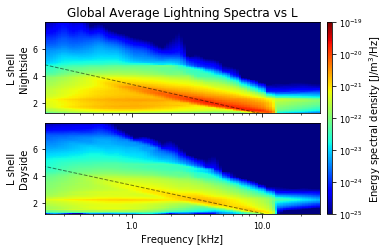

In [51]:
# And do the plot! You can load the above data from "cache.pkl" instead of rerunning
# it if you need to change the figure.

import matplotlib

stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
period_factor = stencil_duration/file_duration

pwr_maps_linear = dict()

for k in pwr_maps.keys():
    pwr_maps_linear[k] = pwr_maps[k]*period_factor/len(filetime_dict)

# Line plot of day + night trends over the US:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5 
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
# Plot spectral density vs L-shell over the US:
dens_vs_L = dict()

lonlims = [-180, 180]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print(np.shape(pwr_maps_linear['night']))
# print np.shape(gridlons), np.shape(gridFs), np.shape(gridLs)
for k in pwr_maps.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)
    dens_vs_L[k] = np.log10(dens_vs_L[k])
    dens_vs_L[k][np.isinf(dens_vs_L[k])] = -100

    
clims = [-25, -19]
cm = plt.cm.jet    
fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


cax = plt.subplot(gs[0:2,1])

# for ind, k in enumerate(dens_vs_L.keys()):
for ind, k in enumerate(['night','day']):
    p = ax[ind].pcolormesh(gridFs/1000., gridLs, dens_vs_L[k].T, vmin = clims[0], vmax=clims[1], cmap = cm, shading='gourad')
#     ax[ind].set_xlabel('Frequency [hz]')
#     ax[ind].set_ylabel('L shell')

    print(ind, k)
    

# Plot the peak fit trendline:
# [ 4.59652279 -0.47714849]
peakfit_day = pow(10, 4.59 - 0.48*gridLs)
# 4.54125744 -0.46263952
peakfit_night = pow(10, 4.54 - 0.46*gridLs)
ax[0].plot(peakfit_night*1e-3, gridLs, 'k--',linewidth=1,alpha=0.5)
ax[1].plot(peakfit_day*1e-3, gridLs, 'k--',linewidth=1,alpha=0.5)
    

ax[0].set_xticklabels([])
ax[0].set_ylabel('L shell\nNightside')
ax[-1].set_ylabel('L shell\nDayside')
ax[-1].set_xlabel('Frequency [kHz]')
ax[0].set_xlim([gridFs[0]/1000, gridFs[-1]/1000])
ax[1].set_xlim([gridFs[0]/1000, gridFs[-1]/1000])
# Colorbar
cb = plt.colorbar(p, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy spectral density [J/m$^3$/Hz]') 

ax[0].set_title('Global Average Lightning Spectra vs L')

fig.subplots_adjust(right=0.85, bottom=0.12)
fig.savefig('lightning_spectra_vs_L_logscale_2020.png', dpi=300)

day
(100, 136)
[ 4.59652279 -0.47714849]
night
(100, 136)
[ 4.54125744 -0.46263952]


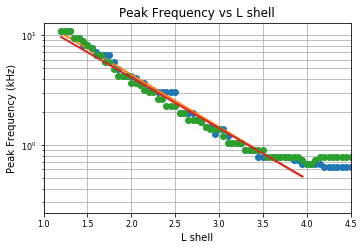

In [47]:
import scipy.optimize

# Find peaks in spectra and do a fit:

def func(x, a, b):
    return a + b*x
# popt, pcov = scipy.optimize.curve_fit(func, gridLs, np.log10(maxF[k]))

# print popt

# fit = func(gridLs, popt[0], popt[1])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

# p , e = optimize.curve_fit(piecewise_linear, gridLs, gridFs[k])
# xd = np.linspace(0, 15, 100)
# pl.plot(x, y, "o")
# pl.plot(xd, piecewise_linear(xd, *p))

fig, ax = plt.subplots(1,1)

dens_vs_L_lin = dict()
for k in pwr_maps.keys():
    dens_vs_L_lin[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)


maxF = dict()
for k in dens_vs_L_lin.keys():
    print(k)
    print(np.shape(dens_vs_L_lin[k]))
    maxF[k] = gridFs[np.argmax(dens_vs_L_lin[k], axis=0)]
    p, e = scipy.optimize.curve_fit(func, gridLs[gridLs < 4], np.log10(maxF[k][gridLs < 4]))
#     p , e = scipy.optimize.curve_fit(piecewise_linear, gridLs, np.log10(gridFs[k]))
    print(p)
    ax.semilogy(gridLs, (maxF[k])/1000., 'o')    
    fit = func(gridLs[gridLs < 4], *p)
    ax.semilogy(gridLs[gridLs < 4], pow(10,fit)/1000., linewidth=2)
    ax.grid('on', which='both')
    ax.set_xlim([1,4.5])
    ax.set_xlabel("L shell")
    ax.set_ylabel('Peak Frequency (kHz)')
    ax.set_title('Peak Frequency vs L shell')